In [67]:
import os
import pickle
import pandas as pd
from inference_weather import download_weather_for_inference
#from inference_ndvi import download_ndvi_for_inference
import geopandas
import matplotlib.pyplot as plt

# Load data for inference

In [68]:
def extract_year_month(filename):
    parts = filename.replace(".csv", "").split("_")
    month = int(parts[1])
    year = int(parts[2])
    return year, month

In [69]:
manual = True

if manual:
    csv_files = [f for f in os.listdir('../data/weather_daily') if f.endswith(".csv")]
    latest_file = max(csv_files, key=lambda f: extract_year_month(f))
    weather_features = pd.read_csv('../data/weather_daily/' + latest_file)
    weather_features.rename(columns={'valid_time':'Month'}, inplace=True)

else:
    weather_features = download_weather_for_inference(save=True)

if manual:
    csv_files = [f for f in os.listdir('../data/ndvi') if f.startswith("ndvi")]
    latest_file = max(csv_files, key=lambda f: extract_year_month(f))
    ndvi_features = pd.read_csv('../data/ndvi/' + latest_file)
    
else:
    ndvi_features = download_ndvi_for_inference()

print(f"Datapoints (weather): {len(weather_features)}")
print(weather_features.columns)

print(f"Datapoints (NDVI): {len(ndvi_features)}")
print(ndvi_features.columns)


Datapoints (weather): 13209
Index(['Lat', 'Lon', 'ssrd_lag1', 'ssrd_lag2', 'ssrd_lag3', 'swvl1_lag1',
       'swvl1_lag2', 'swvl1_lag3', 'swvl2_lag1', 'swvl2_lag2', 'swvl2_lag3',
       't2m_lag1', 't2m_lag2', 't2m_lag3', 'tp_lag1', 'tp_lag2', 'tp_lag3',
       'Month'],
      dtype='object')
Datapoints (NDVI): 61758
Index(['row_id', 'Lat', 'Lon', 'Month', 'NDVI', 'NDVI_lag1', 'NDVI_lag2'], dtype='object')


### Prepare dataset

In [70]:
dataset = weather_features.merge(ndvi_features, on=['Lat', 'Lon', 'Month'], how='left')
dataset.dropna(inplace=True)

X = dataset.copy()
non_feature_cols = ["Month", "row_id", "Lat", "Lon", "NDVI"]
X.drop(columns = non_feature_cols, inplace=True)

X = (X - X.mean(axis=0)) / X.std(axis=0)
X


,ssrd_lag1,ssrd_lag2,ssrd_lag3,swvl1_lag1,swvl1_lag2,swvl1_lag3,swvl2_lag1,swvl2_lag2,swvl2_lag3,t2m_lag1,t2m_lag2,t2m_lag3,tp_lag1,tp_lag2,tp_lag3,NDVI_lag1,NDVI_lag2
1,2.556716,1.994775,0.798524,0.676767,0.752346,0.474351,0.663909,0.645966,0.276868,1.556630,2.035120,1.786018,-1.029662,-0.027880,2.492483,0.891509,0.478273
2,3.006116,2.214281,1.226423,0.601308,0.753129,0.527716,0.597972,0.677535,0.370819,1.459827,1.903739,1.632404,-1.308463,-0.590130,1.259301,1.087082,0.174061
3,3.023053,2.222700,1.237675,0.603369,0.760220,0.549558,0.599316,0.681878,0.380252,1.464378,1.905768,1.625091,-1.300345,-0.533152,1.226231,1.584820,0.649714
4,3.089005,2.281944,1.334722,-1.139655,-0.946729,-1.082742,-1.083778,-0.964147,-1.199441,1.507905,1.927579,1.610032,-1.341549,-0.313020,1.186536,1.531971,-0.248741
5,3.089005,2.281944,1.334722,-1.139655,-0.946729,-1.082742,-1.083778,-0.964147,-1.199441,1.507905,1.927579,1.610032,-1.341549,-0.313020,1.186536,1.450458,-0.042496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6128,-1.197462,-0.986293,-0.784164,-0.547894,-0.759511,-0.612526,-0.546811,-0.708970,-0.518933,-0.883144,-1.199108,-0.581549,1.189133,-0.033448,0.864096,-0.468240,0.722544
6230,-1.225877,-1.059457,-1.137072,-0.670815,-0.759288,-0.557113,-0.698283,-0.721145,-0.464841,-1.627274,-1.839546,-1.018542,0.895050,-0.182583,0.412482,1.153069,0.473116
6231,-1.224405,-1.049722,-1.102687,-0.664130,-0.759066,-0.554000,-0.690504,-0.722023,-0.459642,-1.623351,-1.833340,-1.002526,0.963713,-0.191331,0.490588,0.190734,0.872071
6233,-1.221056,-1.032877,-1.027618,-0.637267,-0.757291,-0.544523,-0.670825,-0.725204,-0.445162,-1.610543,-1.805400,-0.928533,1.167088,-0.195887,0.690070,1.312512,1.006131


# Load Model and Run Inference

In [71]:
model_files = next(os.walk('../models'), (None, None, []))[2]  
file_name = '../models/' + model_files[-1]
model = pickle.load(open(file_name, "rb")) # [-1] to get the latest version


In [72]:
dataset['Pressence_pred'] = model.predict(X[model.feature_names_in_.tolist()])
dataset

,Lat,Lon,ssrd_lag1,ssrd_lag2,ssrd_lag3,swvl1_lag1,swvl1_lag2,swvl1_lag3,swvl2_lag1,swvl2_lag2,...,t2m_lag3,tp_lag1,tp_lag2,tp_lag3,Month,row_id,NDVI,NDVI_lag1,NDVI_lag2,Pressence_pred
1,55.0,10.6,22476206.0,57983484.0,111310340.0,0.371061,0.364825,0.334389,0.370994,0.358065,...,285.59637,0.015119,0.023587,0.073856,2025-12-01,20446,0.1572,0.58820,0.7329,1
2,55.0,12.0,24631480.0,60494504.0,119752570.0,0.365779,0.364880,0.338017,0.366316,0.360316,...,285.31870,0.011303,0.018314,0.056101,2025-12-01,20460,0.5405,0.62095,0.6857,1
3,55.0,12.1,24712708.0,60590810.0,119974560.0,0.365923,0.365382,0.339502,0.366411,0.360626,...,285.30548,0.011414,0.018848,0.055625,2025-12-01,20461,0.2024,0.70430,0.7595,1
4,55.0,12.3,25029008.0,61268530.0,121889250.0,0.243898,0.244546,0.228525,0.246999,0.243248,...,285.27826,0.010851,0.020913,0.055053,2025-12-01,20463,0.0701,0.69545,0.6201,1
5,55.0,12.4,25029008.0,61268530.0,121889250.0,0.243898,0.244546,0.228525,0.246999,0.243248,...,285.27826,0.010851,0.020913,0.055053,2025-12-01,20464,0.0465,0.68180,0.6521,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6128,62.6,17.6,4471560.0,23881812.0,80084744.0,0.285326,0.257800,0.260494,0.285096,0.261445,...,281.31680,0.045486,0.023534,0.050411,2025-12-01,9800,0.3549,0.36050,0.7708,0
6230,62.7,16.9,4335286.0,23044864.0,73122060.0,0.276721,0.257816,0.264262,0.274349,0.260576,...,280.52690,0.041461,0.022136,0.043909,2025-12-01,9652,-0.0743,0.63200,0.7321,0
6231,62.7,17.0,4342342.0,23156218.0,73800456.0,0.277189,0.257831,0.264473,0.274901,0.260514,...,280.55585,0.042401,0.022054,0.045033,2025-12-01,9653,-0.1233,0.47085,0.7940,0
6233,62.7,17.2,4358406.0,23348916.0,75281520.0,0.279069,0.257957,0.265118,0.276297,0.260287,...,280.68960,0.045185,0.022011,0.047905,2025-12-01,9655,0.3156,0.65870,0.8148,0


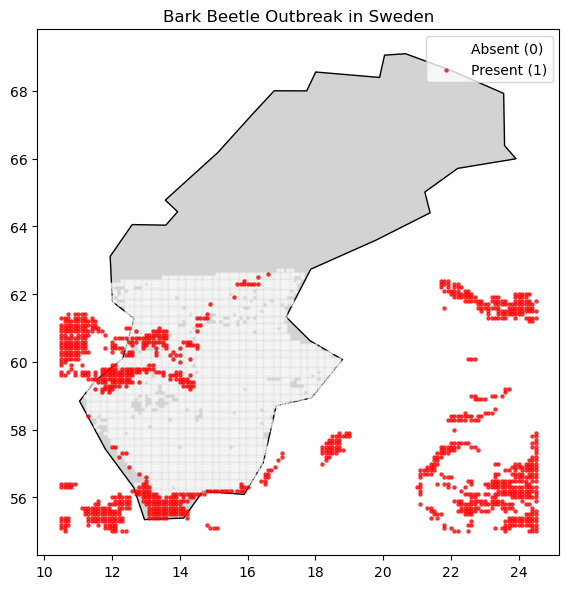

In [81]:
if True:
    gdf = geopandas.GeoDataFrame(
        dataset, geometry=geopandas.points_from_xy(dataset.Lon, dataset.Lat)
        )

    world = geopandas.read_file('../data/country/ne_110m_admin_0_sovereignty.shp')

    # Plot Sweden with t2m as a heatmap
    ax = world[world['NAME'] == 'Sweden'].plot(
        color='lightgrey', edgecolor='black', figsize=(8, 6))

    # Plot presence and absence with different colors
    gdf_absent = gdf[gdf['Pressence_pred'] == 0]
    gdf_present = gdf[gdf['Pressence_pred'] == 1]
    
    gdf_absent.plot(ax=ax, color='white', edgecolor='white', markersize=5, alpha=0.5, label='Absent (0)')
    gdf_present.plot(ax=ax, color='red', markersize=5, alpha=0.7, label='Present (1)')

    ax.set_title('Bark Beetle Outbreak in Sweden')
    ax.legend()
    plt.tight_layout()
    plt.show()